# testing models from CMIP6 historical runs
This script opens up CMIP6 historical model run files with data on precipitation pr and surface temperature tas and calculates monthly anomalies for each region.  Then tests the models for each region.  


In [1]:
import xarray as xr, matplotlib.pyplot as plt
#import sys 
#sys.path.append('/home/563/kb6999/Models') # use this if the function file is in a different directory to the notebook
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load

In [2]:
# import custom functions
import anomaly_function as func # imports the function
import model_figures as func2

In [3]:
# use this to reload the function file if I make any edits to it
func = reload(func) 
func2 = reload(func2)

In [4]:
!ls /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/pr/gr1.5

v20200302


In [5]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
print(institution_dir, tas_dir, pr_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/


## Read in model data

In [6]:
models_tas = func.read_models(institution_dir, tas_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
MPI-ESM-1-2-HAM /g/data/lp01/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ESM-1-2-HAM/historical/r1i1p1f1/Amon/tas/gr1.5/v20190627/*.nc
NESM3 /g/data/lp01/CMIP6/CMIP/NUIST/NESM3/historical/r1i1p1f1/Amon/tas/gr1.5/v20190630/*.nc
Path for MCM-UA-1-0 does not exist
ACCESS-CM2 /g/data/lp01/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/tas/gr1.5/v20190919/*.nc
Model MPI-ESM1-2-HR has different time so is now removed
MPI-ESM1-2-LR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/Amon/tas/gr1.5/v20190710/*.nc
IPSL-CM6A-LR /g/data/lp01/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/tas/gr1.5/v20180803/*.nc
CAS-ESM2-0 /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/tas/gr1.5/v20200302/*.nc
FGOALS-f3-L /g/data/lp01/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/r1i1p1f1/Amon/tas/gr1.5/v20190927/*.nc
FGOALS-g3 /g/data/lp01/CMIP6/CMIP/CAS/FGOALS-g3/historical/r1i1p1f1/Amon/tas/gr1.5/v20190818/*.nc
BCC-ESM1 

In [7]:
models_pr = func.read_models(institution_dir, pr_dir, '1850-01','2015-01')

48 model paths found and loaded into the dictionary "models"
MPI-ESM-1-2-HAM /g/data/lp01/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ESM-1-2-HAM/historical/r1i1p1f1/Amon/pr/gr1.5/v20190627/*.nc
NESM3 /g/data/lp01/CMIP6/CMIP/NUIST/NESM3/historical/r1i1p1f1/Amon/pr/gr1.5/v20190630/*.nc
Path for MCM-UA-1-0 does not exist
ACCESS-CM2 /g/data/lp01/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/pr/gr1.5/v20190919/*.nc
MPI-ESM1-2-HR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/Amon/pr/gr1.5/v20190710/*.nc
MPI-ESM1-2-LR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/Amon/pr/gr1.5/v20190710/*.nc
IPSL-CM6A-LR /g/data/lp01/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/pr/gr1.5/v20180803/*.nc
CAS-ESM2-0 /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/pr/gr1.5/v20200302/*.nc
FGOALS-f3-L /g/data/lp01/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/r1i1p1f1/Amon/pr/gr1.5/v20190927/*.nc
FGOALS-g3 /g/data/lp01/CMIP6/CMIP/CAS/FGOALS-g3/historical/r1i1p

In [40]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.where(models_tas.model.isin(models_pr.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_tas.model), drop = True)
#chekc that the models are the same for both variables and if so print True
models_tas.model.equals(models_pr.model)

True

In [9]:
# combine precipitation and temperature into one dataset
models = xr.Dataset({'tas': models_tas.tas, 'pr': models_pr.pr})
# change the pr units
models['pr'] = models.pr*86400
models

,Array,Chunk
Bytes,10.04 GB,1.38 MB
Shape,"(44, 1980, 120, 240)","(1, 12, 120, 240)"
Count,36929 Tasks,7260 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,20.07 GB,2.76 MB
Shape,"(44, 1980, 120, 240)","(1, 12, 120, 240)"
Count,45181 Tasks,7260 Chunks
Type,float64,numpy.ndarray


In [10]:
# get rid of models with issues
models = models.drop_sel(model=['CIESM'])

In [11]:
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 43 models will be used in all subsequent calculations: 

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'CanESM5'
 'E3SM-1-1' 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-AerChem'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4'
 'GFDL-ESM4' 'GISS-E2-1-G' 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'IITM-ESM'
 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'MIROC6'
 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1'
 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1']


## select out time around krakatoa eruption
I need to select out the time around each eruption or at least store each eruption in a separate array so that I don't get a "minimum" for one eruption in 1891 and the next in 1991

In [12]:
# select out time around krakatoa eruption
models = models.sel(time = slice('1850-01','1900-01'))
models

,Array,Chunk
Bytes,2.98 GB,1.38 MB
Shape,"(43, 601, 120, 240)","(1, 12, 120, 240)"
Count,53312 Tasks,2193 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,5.95 GB,2.76 MB
Shape,"(43, 601, 120, 240)","(1, 12, 120, 240)"
Count,61564 Tasks,2193 Chunks
Type,float64,numpy.ndarray


In [13]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

In [14]:
# save arrays of times relative to each eruption
e_pre5yrs = e_date - 60 * pd.offsets.MonthBegin()
e_pre3mon = e_date - 3 * pd.offsets.MonthBegin()
e_post5yrs = e_date + 61 * pd.offsets.MonthBegin()
e_post10yrs = e_date + 121 * pd.offsets.MonthBegin()

In [15]:
models

,Array,Chunk
Bytes,2.98 GB,1.38 MB
Shape,"(43, 601, 120, 240)","(1, 12, 120, 240)"
Count,53312 Tasks,2193 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,5.95 GB,2.76 MB
Shape,"(43, 601, 120, 240)","(1, 12, 120, 240)"
Count,61564 Tasks,2193 Chunks
Type,float64,numpy.ndarray


## Select out regions
Right now I have all the models stored in one array so from hereafter I can calculate anomalies etc.  

In [16]:
# area weighting 
models_w = models*np.cos(models_tas.lat*(np.pi/180))

In [17]:
# import land fraction data
landfrac_ds = xr.open_dataset('/home/563/kb6999/Models/landfraction_file_grid1.5.nc')
landmask = landfrac_ds.mean(dim='time')

## Anomalies

In [18]:
# use functions to calculate the monthly anomalies for the globe
mon_anom_Glob = func.monthly_anomaly(models_w, '1850-01', '1881-01')

In [19]:
# select out regions for other anomalies 
mon_anom_SH = mon_anom_Glob.sel(lat=slice(-90,0)) 
mon_anom_NH = mon_anom_Glob.sel(lat=slice(0,90)) 
mon_anom_Aus = mon_anom_Glob.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.data==1, drop=True)
mon_anom_EA = mon_anom_Glob.sel(lat=slice(-50,-10), lon=slice(140,155)).where(landmask.data==1, drop=True)

In [20]:
# use function to add in the mmm to the array, labelled as 'Multi-model mean' in the model dimension
multi_model_Glob = func.add_mmm(mon_anom_Glob)
multi_model_SH = func.add_mmm(mon_anom_SH)
multi_model_Aus = func.add_mmm(mon_anom_Aus)
multi_model_EA = func.add_mmm(mon_anom_EA)

In [21]:
# take the lat lon mean before taking the std 
mean_mon_Glob = multi_model_Glob.mean(dim = ['lat','lon'])
mean_mon_SH = multi_model_SH.mean(dim = ['lat','lon'])
mean_mon_Aus = multi_model_Aus.mean(dim = ['lat','lon'])
mean_mon_EA = multi_model_EA.mean(dim = ['lat','lon'])

In [22]:
# calculate the standard deviation for each model over the time period from 1850-1880
std_Glob = mean_mon_Glob.sel(time = slice('1850-01', '1881-01')).std(dim = ['time'])
std_SH = mean_mon_SH.sel(time = slice('1850-01', '1881-01')).std(dim = ['time'])
std_Aus = mean_mon_Aus.sel(time = slice('1850-01', '1881-01')).std(dim = ['time'])
std_EA = mean_mon_EA.sel(time = slice('1850-01', '1881-01')).std(dim = ['time'])

In [23]:
# calculate the mean for each model over the time period from 1850-1880
time_mean_Glob = mean_mon_Glob.sel(time = slice('1850-01', '1881-01')).mean(dim = ['time'])
time_mean_SH = mean_mon_SH.sel(time = slice('1850-01', '1881-01')).mean(dim = ['time'])
time_mean_Aus = mean_mon_Aus.sel(time = slice('1850-01', '1881-01')).mean(dim = ['time'])
time_mean_EA = mean_mon_EA.sel(time = slice('1850-01', '1881-01')).mean(dim = ['time'])

In [24]:
# select out time around krakatoa eruption for graphs and counts, 
K_mean_mon_Glob = mean_mon_Glob.sel(time = slice('1883-08', '1888-08'))
K_mean_mon_SH = mean_mon_SH.sel(time = slice('1883-08', '1888-08'))
K_mean_mon_Aus = mean_mon_Aus.sel(time = slice('1883-08', '1888-08'))
K_mean_mon_EA = mean_mon_EA.sel(time = slice('1883-08', '1888-08'))

# Count below threshold for each model
First select only the values below our threshold, then get the count of unmasked values along the time dimension


In [33]:
# check if anomalies are less than a multiple of the standard deviation in the specificed time period post-eruption
def std_check(anom_dataset, mean, std, std_multiple, start_date, end_date):
    
    import xarray as xr
    
    # select out time period
    dataset_time = anom_dataset.sel(time = slice(f'{start_date}', f'{end_date}'))
    
    # check if the anomalies are less than xx standard deviations in the specificed time periods post eruption
    std_count = dataset_time.where(dataset_time < mean - std_multiple*std).count('time')
    
    return std_count

In [38]:
stdglob = std_check(K_mean_mon_Glob, time_mean_Glob, std_Glob, 1, '1883-08', '1888-08')

In [39]:
stdglob.equals(model_std_count_Glob)

True

In [26]:
# check if the anomalies are less than 1 standard deviation in the 5 years post eruption
model_std_count_Glob = K_mean_mon_Glob.where(K_mean_mon_Glob < time_mean_Glob - std_Glob).count('time')
model_std_count_SH = K_mean_mon_SH.where(K_mean_mon_SH < time_mean_SH - std_SH).count('time')
model_std_count_Aus = K_mean_mon_Aus.where(K_mean_mon_Aus < time_mean_Aus - std_Aus).count('time')
model_std_count_EA = K_mean_mon_EA.where(K_mean_mon_EA < time_mean_EA - std_EA).count('time')

In [25]:
# check if the anomalies are less than 2 standard deviations
model_2std_count_Glob = K_mean_mon_Glob.where(K_mean_mon_Glob < time_mean_Glob - 2*std_Glob).count('time')
model_2std_count_SH = K_mean_mon_SH.where(K_mean_mon_SH < time_mean_SH - 2*std_SH).count('time')
model_2std_count_Aus = K_mean_mon_Aus.where(K_mean_mon_Aus < time_mean_Aus - 2*std_Aus).count('time')
model_2std_count_EA = K_mean_mon_EA.where(K_mean_mon_EA < time_mean_EA - 2*std_EA).count('time')

In [27]:
# check if the anomalies are less than 3 standard deviations 
model_3std_count_Glob = mean_mon_Glob.where(mean_mon_Glob < time_mean_Glob - 3*std_Glob).count('time')
model_3std_count_SH = mean_mon_SH.where(mean_mon_SH < time_mean_SH - 3*std_SH).count('time')
model_3std_count_Aus = mean_mon_Aus.where(mean_mon_Aus < time_mean_Aus - 3*std_Aus).count('time')
model_3std_count_EA = mean_mon_EA.where(mean_mon_EA < time_mean_EA - 3*std_EA).count('time')

In [41]:
# define datasets for plotting, ie select out model and vairable so xr can be converted to 1d np array
std = std_Aus.sel(model='Multi-model mean').tas
std2 = 2*std_Aus.sel(model='Multi-model mean').tas
std3 = 3*std_Aus.sel(model='Multi-model mean').tas
mean = time_mean_Aus.sel(model='Multi-model mean').tas
anom_dataset = K_mean_mon_Aus.sel(model='Multi-model mean').tas

In [44]:
# interpolate the dataset so that there are enough datpoints to use fill_between function properly
# import relevant libraries
from datetime import datetime, timedelta
# make the array with more timepoints (daily)
t = np.arange(datetime(1883,8,31), datetime(1888,8,31), timedelta(days=1)).astype(datetime)
# use the interp function to interpolate the data array
d2 = anom_dataset.interp({'time': t})

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1,

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1,

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1,

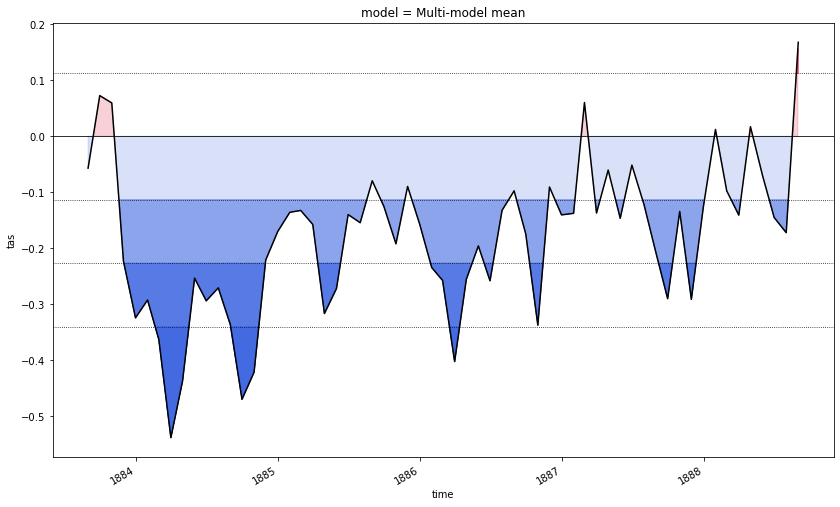

In [45]:
fig = plt.figure(figsize=(14,8))
# alpha is the opacity 
plt.fill_between(d2.time, d2.where(d2>= std).values, std, color='crimson', alpha=0.5)
plt.fill_between(d2.time, d2.where(d2>= mean).values, mean, color='crimson', alpha=0.2)
plt.fill_between(d2.time, d2.where(d2<= mean).values, mean, color='royalblue', alpha=0.2)
plt.fill_between(d2.time, d2.where(d2<= -std).values, -std, color='royalblue', alpha=0.5)
plt.fill_between(d2.time, d2.where(d2<= -std2).values, -std2, color='royalblue', alpha=0.7)
plt.fill_between(d2.time, d2.where(d2<= -std3).values, -std3, color='royalblue', alpha=0.9)
anom_dataset.plot(color='k')
plt.axhline(std, color='k', lw=0.8, ls = ':')
plt.axhline(mean, color='k', lw=0.8)
plt.axhline(-std, color='k', lw=0.8, ls = ':')
plt.axhline(-std2, color='k', lw=0.8, ls = ':')
plt.axhline(-std3, color='k', lw=0.8, ls = ':')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1,

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1,

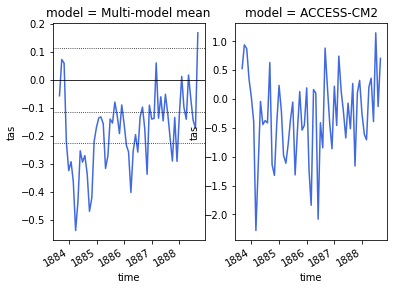

In [46]:
# this graph is better because it shows the actual anomalies
fig, axes = plt.subplots(1,2)
K_mean_mon_Aus.sel(model='Multi-model mean').tas.plot(ax=axes[0], color='royalblue')
K_mean_mon_Aus.sel(model='ACCESS-CM2').tas.plot(ax=axes[1], color='royalblue')
axes[0].axhline(std, color='k', lw=0.8, ls = ':')
axes[0].axhline(mean, color='k', lw=0.8)
axes[0].axhline(-std, color='k', lw=0.8, ls = ':')
axes[0].axhline(-std2, color='k', lw=0.8, ls = ':')

[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  3.5s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.3s
[########################################] | 100

[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.4s
[########################################] | 100

KeyboardInterrupt: 

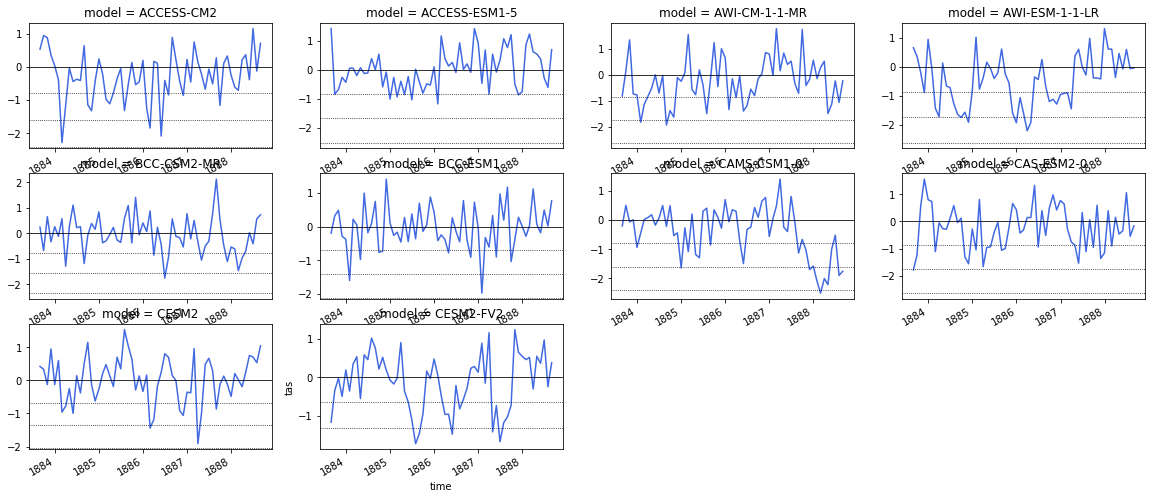

In [148]:
fig = plt.figure(figsize=(20,30))
axs = []

cols = 4
rows = 11

with dask.diagnostics.ProgressBar():
    for i, m in enumerate(K_mean_mon_Aus.model):
        # Add a subplot with a projection
        ax = fig.add_subplot(rows, cols, i+1)

        # Select this model's data and plot it
        K_mean_mon_Aus.sel(model=m).tas.plot(ax=ax, color='royalblue')
        # plot a horizontal line indicating 3 standard deviations
        ax.axhline(0, color='k', lw=0.8)
        ax.axhline((-std_Aus).sel(model=m).tas, color='k', lw=0.8, ls = ':')
        ax.axhline((-std_Aus*2).sel(model=m).tas, color='k', lw=0.8, ls = ':')
        ax.axhline((-std_Aus*3).sel(model=m).tas, color='k', lw=0.8, ls = ':')
        
        # remove x and y axes
        ax.set_xlabel(None)
        ax.set_ylabel(None)

#plt.savefig('statsig_graph_tas.png', dpi=300, bbox_inches='tight')

## need to figure out how to index the model dimension properly

KeyError: 0

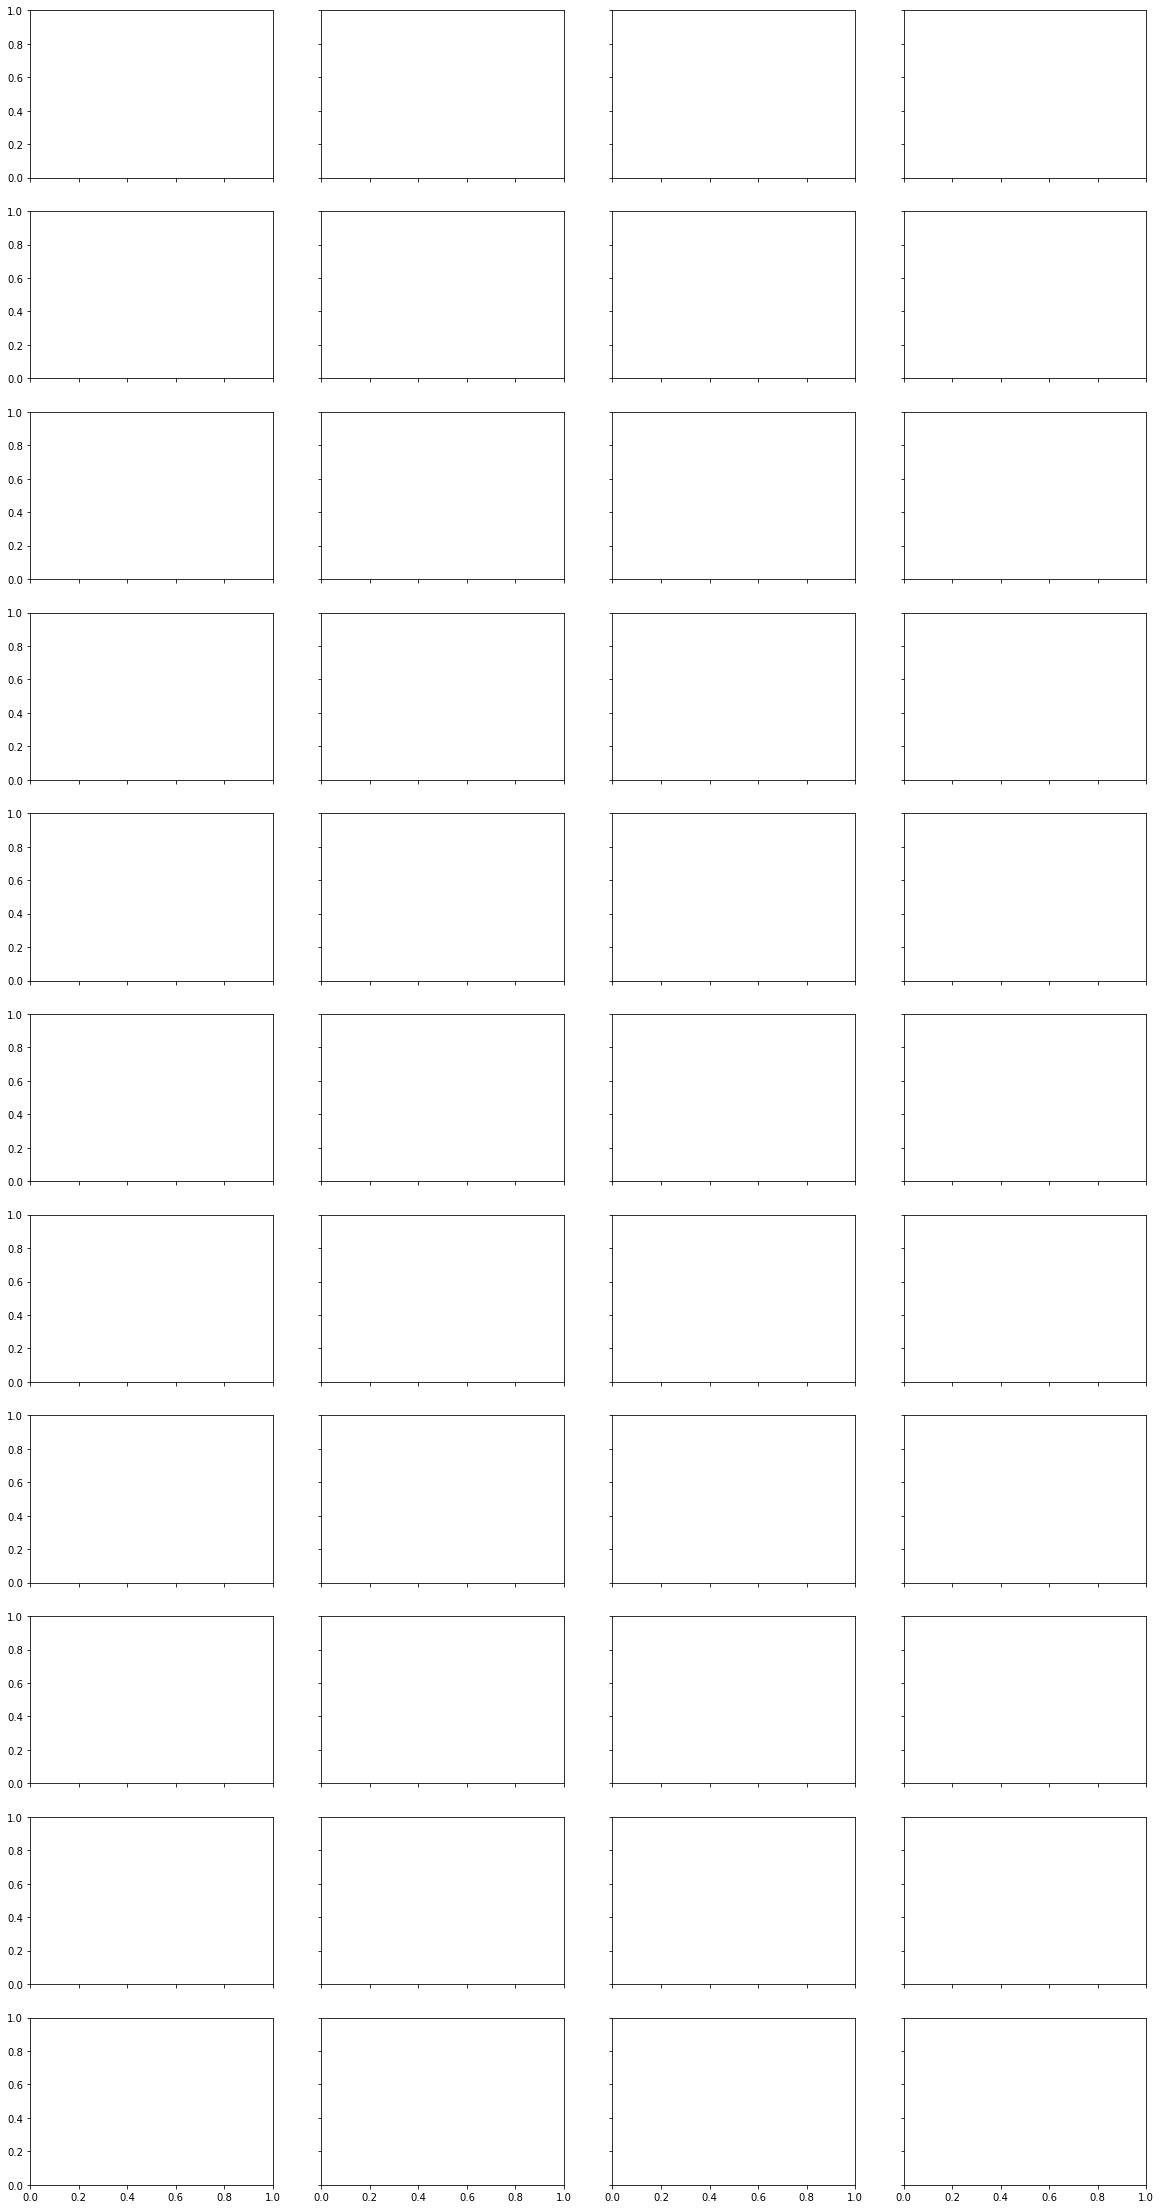

In [150]:
rows = 11
cols=4
fig, axes = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(20,40))

# make subplots for each region
m=0

for r in range(rows):
    for c in range(cols):
        with dask.diagnostics.ProgressBar():
            K_mean_mon_Aus.model[m].tas.plot(ax = axes[r,c], color = 'royalblue')

        # plot a horizontal line indicating 3 standard deviations
        ax.axhline(0, color='k', lw=0.8)
        ax.axhline((-std_Aus).model[m].tas, color='k', lw=0.8, ls = ':')
        ax.axhline((-std_Aus*2).model[m].tas, color='k', lw=0.8, ls = ':')
        ax.axhline((-std_Aus*3).model[m].tas, color='k', lw=0.8, ls = ':')

        # remove x and y axes
        ax.set_xlabel(None)
        ax.set_ylabel(None)

        m=m+1
                
#plt.savefig('statsig_graph_tas.png', dpi=300, bbox_inches='tight')

condition = mean_mon_Glob < time_mean_Glob - std_Glob

## Minimum values for each model
The same idea, this time using 'min' instead of 'count'

In [112]:
# calculate the minimum anomaly (ie the coolest temperature/driest month in the 5 years after krakatoa)
model_min_Glob = K_mean_mon_Glob.min('time')
model_min_SH = K_mean_mon_SH.min('time')
model_min_Aus = K_mean_mon_Aus.min('time')
model_min_EA = K_mean_mon_EA.min('time')

## Date of minimum value for each model¶
Start off by finding the index of the minimum value - argmin.

In [113]:
# calculate the date of the minimum value for each model and store in an array for each region
min_date_Glob = func.min_date(K_mean_mon_Glob, model_min_Glob)
min_date_SH = func.min_date(K_mean_mon_SH, model_min_SH)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/reductions.py:908: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/reductions.py:908: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/reductions.py:908: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/reductions.py:908: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/reductions.py:908: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_a

In [132]:
min_date_Aus = func.min_date(K_mean_mon_Aus, model_min_Aus)
min_date_EA = func.min_date(K_mean_mon_EA, model_min_EA)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/reductions.py:908: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/reductions.py:908: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/reductions.py:908: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis,

In [133]:
stats_tas_Glob = func.combine_stats(model_2std_count_Glob.tas, model_3std_count_Glob.tas, model_min_Glob.tas, min_date_Glob.tas)
stats_tas_SH = func.combine_stats(model_2std_count_SH.tas, model_3std_count_SH.tas, model_min_SH.tas, min_date_SH.tas)
stats_tas_Aus = func.combine_stats(model_2std_count_Aus.tas, model_3std_count_Aus.tas, model_min_Aus.tas, min_date_Aus.tas)
stats_tas_EA = func.combine_stats(model_2std_count_EA.tas, model_3std_count_EA.tas, model_min_EA.tas, min_date_EA.tas)

In [135]:
stats_pr_Glob = func.combine_stats(model_2std_count_Glob.pr, model_3std_count_Glob.pr, model_min_Glob.pr, min_date_Glob.pr)
stats_pr_SH = func.combine_stats(model_2std_count_SH.pr, model_3std_count_SH.pr, model_min_SH.pr, min_date_SH.pr)
stats_pr_Aus = func.combine_stats(model_2std_count_Aus.pr, model_3std_count_Aus.pr, model_min_Aus.pr, min_date_Aus.pr)
stats_pr_EA = func.combine_stats(model_2std_count_EA.pr, model_3std_count_EA.pr, model_min_EA.pr, min_date_EA.pr)

In [72]:
# combine into one dataset for each region and variable 
event_stats_tas_Aus = xr.Dataset({
    'Count 2*std': model_2std_count_Aus.tas,
    'Count 3*std': model_3std_count_Aus.tas,
    'Min': model_min_Aus.tas,
    'Min Date': min_date_Aus.tas,
})

event_stats_tas_Aus

<xarray.Dataset>
Dimensions:      (model: 44)
Coordinates:
  * model        (model) object 'ACCESS-CM2' ... 'Multi-model mean'
Data variables:
    Count 2*std  (model) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    Count 3*std  (model) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    Min          (model) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Min Date     (model) datetime64[ns] 1884-02-29 1886-01-31 ... 1884-03-31

In [77]:
event_stats_tas_Aus_df = event_stats_tas_Aus.to_dataframe()
event_stats_tas_Aus_df.round(decimals=2)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,Count 2*std,Count 3*std,Min,Min Date
model,,,,
ACCESS-CM2,3,0,-2.28,1884-02-29
ACCESS-ESM1-5,0,0,-1.17,1886-01-31
AWI-CM-1-1-MR,2,1,-1.93,1884-08-31
AWI-ESM-1-1-LR,5,0,-2.21,1886-03-31
BCC-CSM2-MR,1,0,-1.76,1886-06-30
BCC-ESM1,2,0,-1.97,1887-01-31
CAMS-CSM1-0,8,2,-2.51,1888-02-29
CAS-ESM2-0,1,4,-1.78,1883-08-31
CESM2,2,0,-1.91,1887-03-31


## figure out how to convert datafram to latex table 

## Climtas event detection
The climtas library has some functions for event detection - it will find runs where a condition is true for multiple times, then let you run a function to calculate statistics for each event

In [ ]:
K_mean_mon_Glob < K_time_mean_Glob - 2*std_Glob

In [ ]:
import climtas

events = climtas.event.find_events(mean_mon_Glob.pr < time_mean_Glob.pr - std_Glob.pr, min_duration=2)
events

In [ ]:
coords = climtas.event.event_coords(mean_mon_Glob.pr, events)

def stat_func(event_data):
    return {'min': event_data.min().values,
            'min_date': event_data.time[event_data.argmin()].values}
    
minimum = climtas.event.map_events(da, events, stat_func)

coords.join(minimum)